# Example of a sky simulation using RASCIL / OSKAR

In this example we take an arbitrary sky and use karabo to simulate the visibilities. We simulate the visibilites once using OSKAR and once using RASCIL. For the imaging we use RASCIL in both cases. We also show the usage of primary beams in karabo.

In [1]:
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.beam import generate_gaussian_beam_data
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from rascil.processing_components import create_visibility_from_ms
from karabo.simulator_backend import SimulatorBackend

import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime, timedelta
from karabo.util.ska_sdp_datamodels.visibility.vis_io_ms import (  # type: ignore[attr-defined] # noqa: E501
    export_visibility_to_ms,
)
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig
from ska_sdp_datamodels.image import create_image

import matplotlib.pyplot as plt

%matplotlib inline

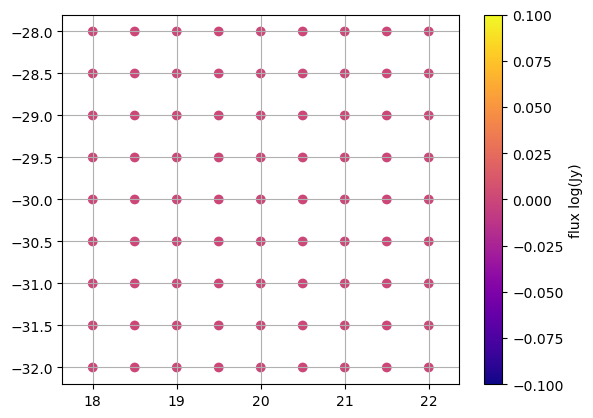

In [2]:
# Read in and plot the sky model
sky = SkyModel.sky_test()

# Sky Model if you want ONE POINT SOURCE ONLY
# sky = SkyModel()
# sky_data = np.array([[20.0, -30.0, 1]])
# sky.add_point_sources(sky_data)

sky.explore_sky(phase_center=(20, -30), wcs_enabled=False)

In [3]:
# Parameter definition
ra_deg = 20
dec_deg = -30
start_time = datetime(2000, 3, 20, 12, 6, 39)
obs_length = timedelta(hours=3, minutes=5, seconds=0, milliseconds=0)
start_freq = 1.5e9
freq_bin = 1.0e7
number_of_time_steps = 10
number_of_channels = 5

In [4]:
# Set Imaging parameters
imaging_npixel = 1024
dirty_imager_config = RascilDirtyImagerConfig(
    imaging_npixel=imaging_npixel,
    imaging_cellsize=2 / 180 * np.pi / 1024,
)
dirty_imager = RascilDirtyImager(dirty_imager_config)

In [5]:
# Simulation settings that are the same for OSKAR and RASCIL
observation = Observation(
    phase_centre_ra_deg=ra_deg,
    phase_centre_dec_deg=dec_deg,
    start_date_and_time=start_time,
    length=obs_length,
    number_of_time_steps=number_of_time_steps,
    start_frequency_hz=start_freq,
    frequency_increment_hz=freq_bin,
    number_of_channels=number_of_channels,
)
simulation = InterferometerSimulation(
    channel_bandwidth_hz=1.0e7,
    time_average_sec=8,
    ignore_w_components=True,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=False,
    use_dask=False,
    station_type="Isotropic beam",  # This is only used by OSKAR (beam setting in OSKAR)
)

In [6]:
#### RASCIL SIMULATION
# Load the telescope (SKA-Mid)
telescope_r = Telescope.constructor("MID", backend=SimulatorBackend.RASCIL)

visibility_r = simulation.run_simulation(
    telescope=telescope_r,
    sky=sky,
    observation=observation,
    backend=SimulatorBackend.RASCIL,
    visibility_path="/tmp/RASCIL.MS",
)

#### OSKAR SIMULATION
telescope_o = Telescope.constructor("SKA1MID")

visibility_o = simulation.run_simulation(
    telescope_o,
    sky,
    observation,
    visibility_path="/tmp/OSKAR.MS",
)

Matched path /tmp/RASCIL.MS to format MS
Matched path /tmp/OSKAR.MS to format MS
Saved visibility to /tmp/OSKAR.MS


Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Imager-Dirty-RBXZdvdk37 for disk-cache for dirty.fits


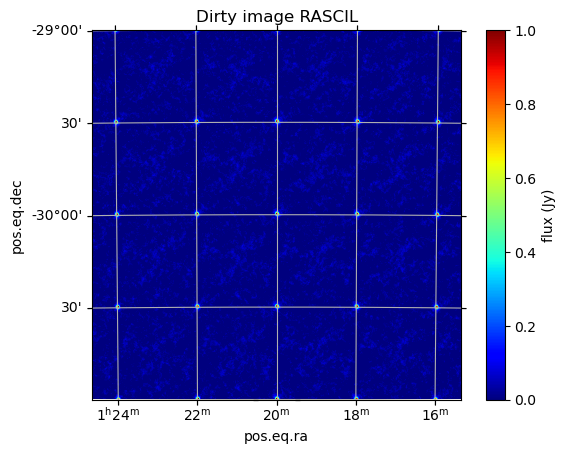

Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Imager-Dirty-J3F1LDuP27 for disk-cache for dirty.fits


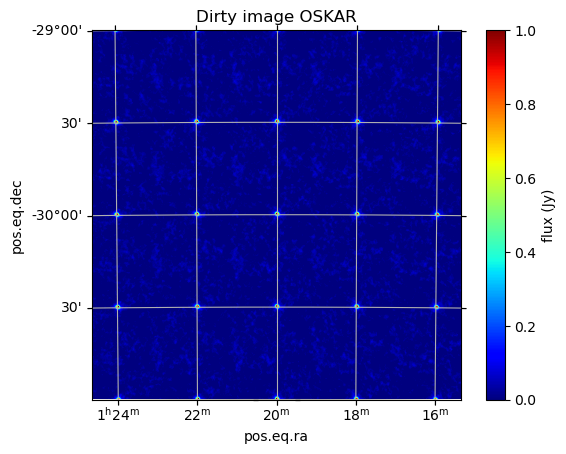

In [7]:
# Imaging with RASCIL
dirty_rascil = dirty_imager.create_dirty_image(visibility_r)
dirty_rascil.plot(title="Dirty image RASCIL", vmin=0, vmax=1.0)

# We use the Imager to check the simulation
dirty_oskar = dirty_imager.create_dirty_image(visibility_o)
dirty_oskar.plot(title="Dirty image OSKAR", vmin=0, vmax=1.0)

Compare the dirty images received from the RASCIL/OSKAR visibility simulation.

Text(0.5, 1.0, 'Difference between dirty images of OSKAR and RASCIL')

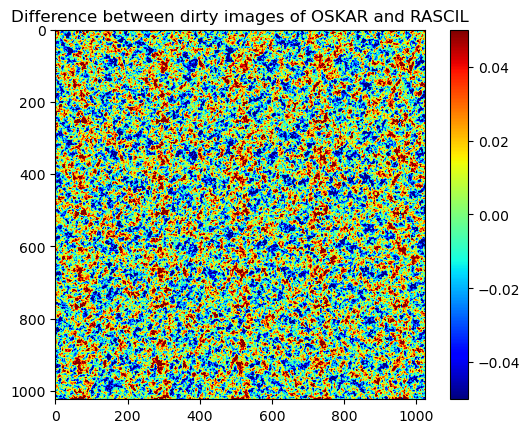

In [8]:
dirty_diff = dirty_oskar.data[0][0] - dirty_rascil.data[0][0]
plt.imshow(dirty_diff, cmap="jet", vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.title("Difference between dirty images of OSKAR and RASCIL")

# Simulation with OSKAR/RASCIL using a primary beam

We are performing the same simulation as above but this time using a primary beam. In this example we are simulating using a simple Gaussian beam. OSKAR can only simulate Gaussian beams, whereas RASCIL can simulate arbitrary primary beams

<xarray.Image>
Dimensions:       (frequency: 5, polarisation: 1, y: 1024, x: 1024)
Coordinates:
  * frequency     (frequency) float64 1.5e+09 1.51e+09 ... 1.53e+09 1.54e+09
  * polarisation  (polarisation) <U1 'I'
  * y             (y) float64 -0.5411 -0.541 -0.541 ... -0.5062 -0.5062 -0.5062
  * x             (x) float64 0.3316 0.3316 0.3317 ... 0.3664 0.3665 0.3665
Data variables:
    pixels        (frequency, polarisation, y, x) float64 3.495e-39 ... 0.0
Attributes:
    data_model:           Image
    _polarisation_frame:  stokesI
    _projection:          ('RA---SIN', 'DEC--SIN')
    spectral_type:        FREQ
    clean_beam:           None
    refpixel:             [513. 513.   1.   1.]
    channel_bandwidth:    10000000.0
    ra:                   0.3490658503988659
    dec:                  -0.5235987755982988


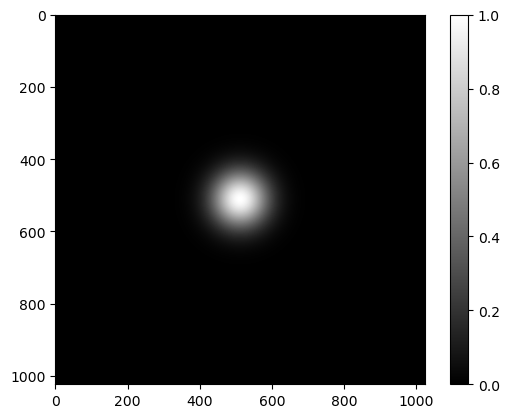

In [9]:
# For RASCIL we have to generate the beam ourself
primary_beam = create_image(
    npixel=dirty_imager_config.imaging_npixel,
    cellsize=dirty_imager_config.imaging_cellsize,
    phasecentre=SkyCoord(ra_deg, dec_deg, unit=(u.deg, u.deg), frame="icrs"),
    frequency=start_freq,
    channel_bandwidth=freq_bin,
    nchan=number_of_channels,
)

fwhm_degrees = 0.25
fwhm_pixels = fwhm_degrees / np.degrees(dirty_imager_config.imaging_cellsize)
beam = generate_gaussian_beam_data(
    fwhm_pixels=fwhm_pixels,
    x_size=dirty_imager_config.imaging_npixel,
    y_size=dirty_imager_config.imaging_npixel,
)
primary_beam["pixels"][0][0] = beam

print(primary_beam)
plt.imshow(primary_beam["pixels"].data[0, 0, :, :], cmap="gray")
plt.colorbar()

In [10]:
# Simulation settings that are the same for OSKAR and RASCIL
observation = Observation(
    phase_centre_ra_deg=ra_deg,
    phase_centre_dec_deg=dec_deg,
    start_date_and_time=start_time,
    length=obs_length,
    number_of_time_steps=number_of_time_steps,
    start_frequency_hz=start_freq,
    frequency_increment_hz=freq_bin,
    number_of_channels=number_of_channels,
)
simulation = InterferometerSimulation(
    channel_bandwidth_hz=1.0e7,
    time_average_sec=8,
    ignore_w_components=True,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=False,
    use_dask=False,
    station_type="Gaussian beam",  # This is only used by OSKAR (beam setting in OSKAR)
    gauss_beam_fwhm_deg=fwhm_degrees,
    gauss_ref_freq_hz=start_freq,
)

In [11]:
#### RASCIL SIMULATION
# Load the telescope (SKA-Mid)
telescope_r = Telescope.constructor("MID", backend=SimulatorBackend.RASCIL)

visibility_r = simulation.run_simulation(
    telescope=telescope_r,
    sky=sky,
    observation=observation,
    backend=SimulatorBackend.RASCIL,
    visibility_path="/tmp/RASCIL.MS",
    primary_beam=primary_beam,  # Here we need to specify the beam!!
)

#### OSKAR SIMULATION
telescope_o = Telescope.constructor("SKA1MID")

visibility_o = simulation.run_simulation(
    telescope_o,
    sky,
    observation,
    visibility_path="/tmp/OSKAR.MS",
)

Matched path /tmp/RASCIL.MS to format MS
Matched path /tmp/OSKAR.MS to format MS
Saved visibility to /tmp/OSKAR.MS


Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Imager-Dirty-6nkzkKPamd for disk-cache for dirty.fits


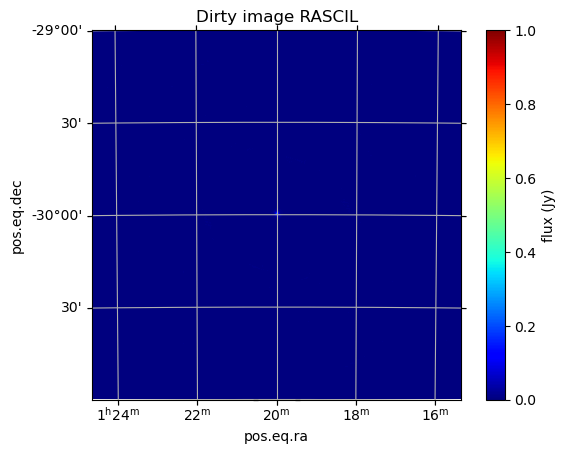

Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Imager-Dirty-XJwVVtgOeo for disk-cache for dirty.fits


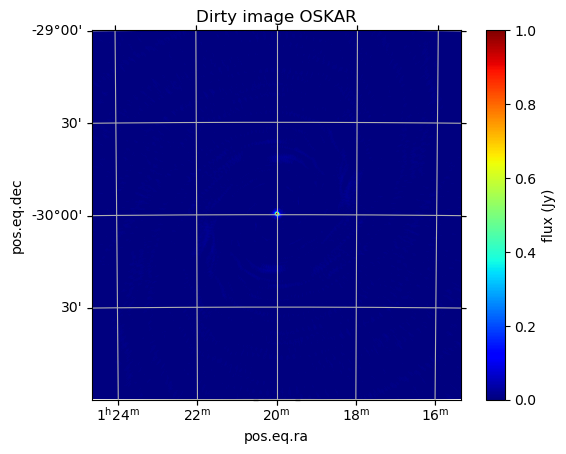

In [12]:
# Imaging with RASCIL
dirty_rascil = dirty_imager.create_dirty_image(visibility_r)
dirty_rascil.plot(title="Dirty image RASCIL", vmin=0, vmax=1.0)

# We use the Imager to check the simulation
dirty_oskar = dirty_imager.create_dirty_image(visibility_o)
dirty_oskar.plot(title="Dirty image OSKAR", vmin=0, vmax=1.0)

# Investigate visibilities

In [13]:
vis_r = create_visibility_from_ms(str(visibility_r.path))[0]
vis_o = create_visibility_from_ms(str(visibility_o.path))[0]

In [14]:
print(vis_r)

<xarray.Visibility>
Dimensions:            (time: 10, baselines: 19503, frequency: 5,
                        polarisation: 1, spatial: 3)
Coordinates:
  * time               (time) float64 4.453e+09 4.453e+09 ... 4.453e+09
  * baselines          (baselines) object MultiIndex
  * antenna1           (baselines) int64 0 0 0 0 0 0 ... 194 194 194 195 195 196
  * antenna2           (baselines) int64 0 1 2 3 4 5 ... 194 195 196 195 196 196
  * frequency          (frequency) float64 1.505e+09 1.515e+09 ... 1.545e+09
  * polarisation       (polarisation) <U1 'I'
  * spatial            (spatial) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.11e+03 1.11e+03 ... 1.11e+03 1.11e+03
    datetime           (time) datetime64[ns] 2000-01-01T15:39:28.908284116 .....
    vis                (time, baselines, frequency, polarisation) complex128 ...
    weight             (time, baselines, frequency, polarisation) float64 1.0...
    flags              (time, baselines, frequency, 

In [15]:
print(vis_o)

<xarray.Visibility>
Dimensions:            (time: 10, baselines: 19503, frequency: 5,
                        polarisation: 4, spatial: 3)
Coordinates:
  * time               (time) float64 4.46e+09 4.46e+09 ... 4.46e+09 4.46e+09
  * baselines          (baselines) object MultiIndex
  * antenna1           (baselines) int64 0 0 0 0 0 0 ... 194 194 194 195 195 196
  * antenna2           (baselines) int64 0 1 2 3 4 5 ... 194 195 196 195 196 196
  * frequency          (frequency) float64 1.5e+09 1.51e+09 ... 1.54e+09
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * spatial            (spatial) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.11e+03 1.11e+03 ... 1.11e+03 1.11e+03
    datetime           (time) datetime64[ns] 2000-03-20T12:06:39.000000232 .....
    vis                (time, baselines, frequency, polarisation) complex128 ...
    weight             (time, baselines, frequency, polarisation) float64 0.0...
    flags              (time, base

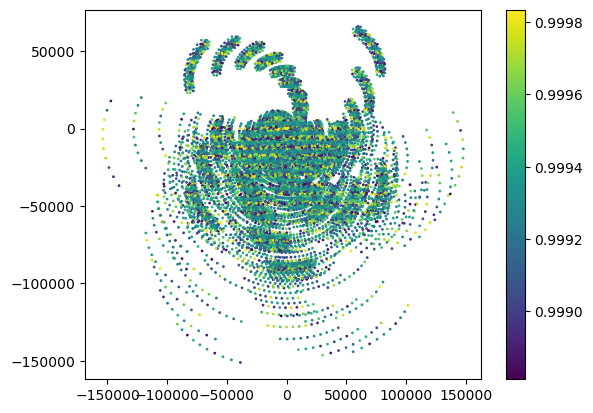

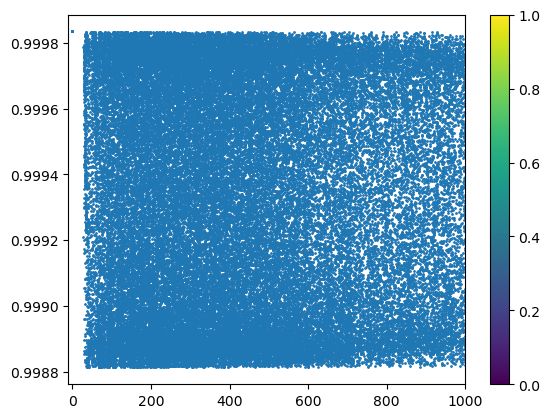

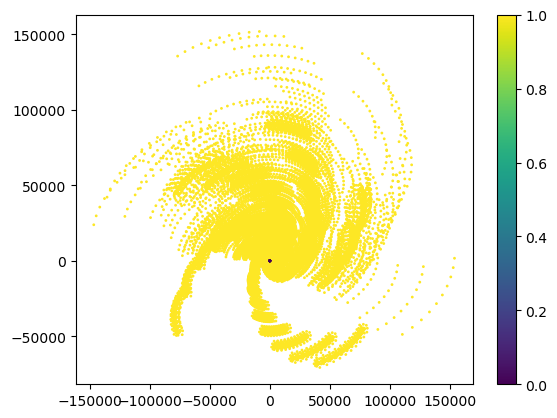

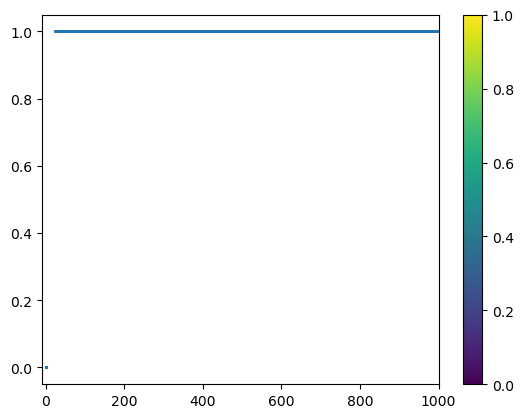

In [16]:
vis_both = [vis_r, vis_o]
for v in vis_both:
    visi = v["vis"].data
    uvw = v["uvw"].data

    plt.figure()
    plt.scatter(uvw[:, :, 0], uvw[:, :, 1], c=abs(visi[:, :, 0, 0]), s=1)
    # plt.xlim(-100, 100)
    # plt.ylim(-100, 100)
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.scatter(
        np.sqrt(uvw[:, :, 0] ** 2 + uvw[:, :, 1] ** 2), abs(visi[:, :, 0, 0]), s=1
    )
    plt.xlim(-10, 1000)
    plt.colorbar()
    plt.show()

    uv = np.sqrt(uvw[:, :, 0] ** 2 + uvw[:, :, 1] ** 2)

    uv_0 = np.where(uv == 0)
    vis_0 = abs(visi[uv_0])
    nonzero_in = np.nonzero(vis_0)